## XGBoost - pair distribution function (PDF) - structure type 7cat unbalanced

In [1]:
import numpy as np
import pandas as pd
import h5py
from debyecalculator import DebyeCalculator
from ase.io import read
import glob
import os
import sys
import random
import tiktoken
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, r2_score, mean_absolute_error, root_mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
import pycm
from ast import literal_eval
import sys
sys.path.append("/mnt/c/Users/44907688G/Documents/home_vicky/LLMs_models/gptchem-gptj/plotutils/")
from plotutils import *
plt.style.use("/mnt/c/Users/44907688G/Documents/home_vicky/LLMs_models/gptchem-gptj/plotutils/kevin.mplstyle")

random.seed(42)
np.random.seed(42)

/home/vicky/anaconda3/envs/debyecalculator_env/lib/python3.9/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
def process_xyz_files():
    # Initialise DebyeCalculator object
    calc = DebyeCalculator()
    print(calc)
    
    # Load XYZ files
    XYZ_files = sorted(glob.glob("../xyz_files/*.xyz"))
    random.shuffle(XYZ_files)

    # Calculate Pair Distribution Function for all XYZ files
    scattering_files = []
    structure_types = []
    num_atoms = []

    for iter, xyz_file in enumerate(XYZ_files):
        # Extract structure type
        structure_type = os.path.basename(xyz_file).split('_')[0]

        # Calculate the scattering pattern
        scatt_x, scatt_Int = calc.gr(structure_source=xyz_file)

        # Normalise the scattering files
        scatt_Int /= max(scatt_Int)
        scattering_files.append(scatt_Int)

        # Increment the count for this structure type
        structure_types.append(structure_type)

        atoms = read(xyz_file)
        num_atoms.append(len(atoms))

    return scattering_files, structure_types, num_atoms

In [3]:
# Simulate scattering data
scattering_files, structure_types, num_atoms = process_xyz_files()

/tmp/ipykernel_12127/1612413307.py:3: UserWarning: Warning: Your system might have a CUDA-enabled GPU, but CUDA is not available. Computations will run on the CPU instead. For optimal performance, please install Pytorch with CUDA support. If you do not have a CUDA-enabled CPU, you can surpress this warning by specifying the 'device' argument as 'cpu'
  calc = DebyeCalculator()


DebyeCalculator{'qmin': 1.0, 'qmax': 30.0, 'qdamp': 0.04, 'qstep': 0.05, 'rmin': 0.0, 'rmax': 20.0, 'rstep': 0.01, 'rthres': 0.0, 'biso': 0.3}


In [4]:
len(scattering_files[0])

2000

In [5]:
np.set_printoptions(threshold=sys.maxsize)

In [6]:
scattering_files[0]

array([ 0.00000000e+00, -1.24081259e-03, -2.43981788e-03, -3.55886901e-03,
       -4.56686504e-03, -5.44242794e-03, -6.17583841e-03, -6.76981779e-03,
       -7.23938225e-03, -7.61045050e-03, -7.91762862e-03, -8.20107665e-03,
       -8.50310456e-03, -8.86432454e-03, -9.32015758e-03, -9.89775546e-03,
       -1.06134415e-02, -1.14714708e-02, -1.24634868e-02, -1.35693504e-02,
       -1.47587219e-02, -1.59940217e-02, -1.72333848e-02, -1.84345916e-02,
       -1.95586290e-02, -2.05732044e-02, -2.14555021e-02, -2.21943278e-02,
       -2.27909349e-02, -2.32591350e-02, -2.36239322e-02, -2.39193980e-02,
       -2.41856966e-02, -2.44655330e-02, -2.48004626e-02, -2.52271071e-02,
       -2.57741194e-02, -2.64594071e-02, -2.72887163e-02, -2.82550789e-02,
       -2.93392893e-02, -3.05116437e-02, -3.17345411e-02, -3.29658240e-02,
       -3.41622792e-02, -3.52836587e-02, -3.62959877e-02, -3.71749178e-02,
       -3.79074812e-02, -3.84935588e-02, -3.89457569e-02, -3.92884202e-02,
       -3.95554863e-02, -

In [7]:
encoding = tiktoken.encoding_for_model("text-davinci-003")
num_tokens = len(encoding.encode(str(scattering_files[0])))
num_tokens

19524

In [8]:
len(scattering_files[0].round(3)[::15])

134

In [9]:
encoding = tiktoken.encoding_for_model("text-davinci-003")
num_tokens = len(encoding.encode(str(scattering_files[0].round(3)[::15])))
num_tokens

551

In [10]:
scattering_patterns = []

In [11]:
for i in np.arange(len(scattering_files)):
    pattern = scattering_files[i].round(3)[::15]
    scattering_patterns.append(pattern)

In [12]:
len(scattering_patterns[0])

134

### prepare clasification dataset for structure type

In [13]:
scattering_patterns = np.array(scattering_patterns)

In [14]:
le = LabelEncoder()
encoded_structure_types = le.fit_transform(structure_types)

In [15]:
class_indices = {i: np.where(encoded_structure_types == i)[0] for i in np.unique(encoded_structure_types)}

In [16]:
class_indices

{0: array([   5,   41,   50,   57,   68,   69,   77,   83,   86,   92,  104,
         105,  115,  118,  120,  124,  128,  137,  141,  146,  155,  168,
         179,  188,  193,  203,  222,  235,  253,  265,  268,  270,  275,
         292,  317,  366,  378,  382,  390,  394,  395,  403,  413,  417,
         463,  488,  502,  516,  526,  540,  548,  552,  581,  582,  601,
         611,  612,  619,  635,  639,  643,  653,  656,  667,  677,  682,
         697,  700,  711,  713,  717,  722,  724,  730,  732,  753,  755,
         764,  776,  811,  816,  831,  837,  843,  849,  855,  868,  885,
         898,  911,  917,  926,  934,  964,  971,  977,  989,  997, 1004,
        1006, 1010, 1011, 1019, 1023, 1034, 1038, 1039, 1042, 1046, 1058,
        1062, 1069, 1097, 1098, 1109, 1120, 1127, 1146, 1154, 1157, 1159,
        1164, 1180, 1183, 1184, 1188, 1209, 1213, 1221, 1234, 1238, 1243,
        1257, 1264, 1299, 1310, 1314, 1327, 1342, 1367, 1373, 1389, 1395,
        1410, 1419, 1429, 1448, 145

In [17]:
for cat in class_indices:
    print(cat)

0
1
2
3
4
5
6


In [18]:
for indices in class_indices.values():
    print(len(indices))

209
342
95
1007
38
76
190


In [19]:
indices = np.arange(len(num_atoms))
indices

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
        143,  144,  145,  146,  147,  148,  149,  1

In [20]:
MAX_TEST_DATA = 2000
train_size = 200

In [21]:
train_indices, val_test_indices = train_test_split(
    indices, 
    train_size=train_size,
    test_size=min(len(indices)-train_size, MAX_TEST_DATA),
    random_state=42,
    stratify=encoded_structure_types,
)

In [22]:
len(train_indices)

200

In [23]:
len(val_test_indices)

1757

In [24]:
y_val_test = encoded_structure_types[val_test_indices]

In [25]:
val_indices, test_indices = train_test_split(
    val_test_indices, 
    test_size=0.5, 
    random_state=42,
    stratify=y_val_test
)

In [26]:
len(val_indices)

878

In [27]:
len(test_indices)

879

In [28]:
X_train, y_train = scattering_patterns[train_indices], encoded_structure_types[train_indices]
X_val, y_val = scattering_patterns[val_indices], encoded_structure_types[val_indices]
X_test, y_test = scattering_patterns[test_indices], encoded_structure_types[test_indices]

In [29]:
print(np.unique(y_train, return_counts=True))
for n in np.unique(y_train):
    print(f'{n}: {np.unique(y_train, return_counts=True)[1][n]/len(y_train)*100}')

(array([0, 1, 2, 3, 4, 5, 6]), array([ 21,  35,  10, 103,   4,   8,  19]))
0: 10.5
1: 17.5
2: 5.0
3: 51.5
4: 2.0
5: 4.0
6: 9.5


In [30]:
print(np.unique(y_val, return_counts=True))
for n in np.unique(y_val):
    print(f'{n}: {np.unique(y_val, return_counts=True)[1][n]/len(y_val)*100}')

(array([0, 1, 2, 3, 4, 5, 6]), array([ 94, 153,  43, 452,  17,  34,  85]))
0: 10.70615034168565
1: 17.425968109339408
2: 4.89749430523918
3: 51.48063781321185
4: 1.9362186788154898
5: 3.8724373576309796
6: 9.681093394077449


In [31]:
print(np.unique(y_test, return_counts=True))
for n in np.unique(y_test):
    print(f'{n}: {np.unique(y_test, return_counts=True)[1][n]/len(y_test)*100}')

(array([0, 1, 2, 3, 4, 5, 6]), array([ 94, 154,  42, 452,  17,  34,  86]))
0: 10.693970420932878
1: 17.51990898748578
2: 4.778156996587031
3: 51.42207053469852
4: 1.9340159271899888
5: 3.8680318543799777
6: 9.783845278725826


In [32]:
X_train[0]

array([ 0.   , -0.008, -0.016, -0.024, -0.031, -0.039, -0.047, -0.053,
       -0.06 , -0.068, -0.073, -0.077, -0.085, -0.091, -0.091, -0.097,
       -0.107, -0.073,  0.635,  0.708, -0.07 , -0.119, -0.111, -0.11 ,
       -0.116, -0.089,  0.112, -0.015, -0.108, -0.104, -0.098, -0.016,
        0.403,  0.064, -0.08 , -0.082, -0.05 ,  0.092, -0.021, -0.063,
       -0.049,  0.096,  0.077, -0.037, -0.038, -0.032, -0.028, -0.024,
       -0.019, -0.016, -0.012, -0.008,  0.009,  0.009,  0.   ,  0.002,
        0.003,  0.005,  0.006,  0.007,  0.007,  0.008,  0.008,  0.008,
        0.008,  0.008,  0.007,  0.006,  0.005,  0.005,  0.003,  0.002,
        0.002,  0.001, -0.   , -0.001, -0.002, -0.003, -0.003, -0.004,
       -0.004, -0.005, -0.005, -0.005, -0.005, -0.005, -0.004, -0.004,
       -0.004, -0.003, -0.003, -0.002, -0.002, -0.001, -0.001, -0.   ,
        0.001,  0.001,  0.001,  0.002,  0.002,  0.003,  0.003,  0.003,
        0.003,  0.003,  0.003,  0.003,  0.003,  0.003,  0.002,  0.002,
      

### train and evaluate classifier

In [33]:
clf = XGBClassifier(
    n_estimators=500, 
    random_state=42, 
    early_stopping_rounds=10, 
    #use_label_encoder=False, 
    eval_metric='mlogloss'
)

In [34]:
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)

[0]	validation_0-mlogloss:1.28500	validation_1-mlogloss:1.46071
[1]	validation_0-mlogloss:0.96352	validation_1-mlogloss:1.22516
[2]	validation_0-mlogloss:0.74513	validation_1-mlogloss:1.07674
[3]	validation_0-mlogloss:0.58813	validation_1-mlogloss:0.96907
[4]	validation_0-mlogloss:0.47276	validation_1-mlogloss:0.88938
[5]	validation_0-mlogloss:0.37590	validation_1-mlogloss:0.82858
[6]	validation_0-mlogloss:0.30086	validation_1-mlogloss:0.78518
[7]	validation_0-mlogloss:0.24563	validation_1-mlogloss:0.75087
[8]	validation_0-mlogloss:0.20208	validation_1-mlogloss:0.73052
[9]	validation_0-mlogloss:0.16770	validation_1-mlogloss:0.70978
[10]	validation_0-mlogloss:0.14136	validation_1-mlogloss:0.68713
[11]	validation_0-mlogloss:0.12106	validation_1-mlogloss:0.67261
[12]	validation_0-mlogloss:0.10416	validation_1-mlogloss:0.65920
[13]	validation_0-mlogloss:0.09080	validation_1-mlogloss:0.65417
[14]	validation_0-mlogloss:0.08039	validation_1-mlogloss:0.64592
[15]	validation_0-mlogloss:0.07140	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [35]:
best_iteration = clf.best_iteration
best_iteration

25

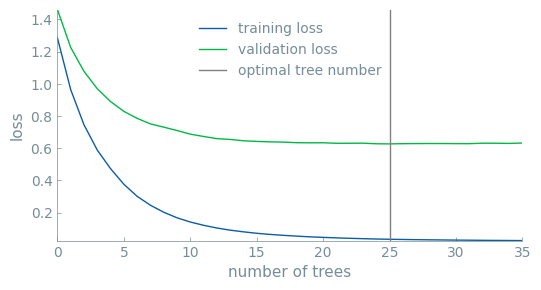

In [36]:
results = clf.evals_result()

plt.figure(figsize=(6, 3))
plt.plot(results["validation_0"]["mlogloss"], label="training loss")
plt.plot(results["validation_1"]["mlogloss"], label="validation loss")
plt.axvline(best_iteration, color="gray", label="optimal tree number")
plt.xlabel("number of trees")
plt.ylabel("loss")
plt.legend()

In [37]:
y_pred = clf.predict(X_test)
y_pred

array([3, 5, 0, 3, 2, 3, 3, 3, 3, 3, 6, 3, 3, 1, 1, 1, 1, 1, 1, 6, 3, 3,
       0, 3, 1, 3, 3, 3, 3, 1, 0, 1, 0, 6, 3, 0, 3, 2, 3, 4, 0, 3, 0, 6,
       3, 3, 3, 1, 3, 1, 5, 3, 3, 3, 3, 4, 1, 3, 3, 3, 4, 1, 3, 0, 1, 3,
       3, 3, 1, 1, 0, 3, 3, 3, 1, 3, 3, 4, 1, 3, 2, 3, 3, 3, 3, 3, 3, 3,
       6, 6, 1, 5, 1, 6, 6, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 3, 0, 3, 6, 3,
       3, 3, 3, 3, 3, 3, 3, 6, 3, 3, 6, 3, 2, 3, 3, 6, 1, 0, 3, 0, 6, 3,
       3, 0, 3, 5, 3, 0, 3, 3, 3, 2, 6, 3, 3, 3, 3, 3, 1, 1, 3, 0, 0, 3,
       1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 6, 3, 1, 1, 0, 3, 3, 1, 1, 3, 3,
       3, 3, 3, 6, 3, 3, 6, 3, 0, 0, 3, 0, 1, 3, 3, 1, 3, 6, 1, 3, 3, 1,
       3, 3, 6, 2, 0, 3, 3, 3, 1, 3, 3, 0, 0, 3, 3, 3, 1, 0, 3, 3, 3, 3,
       3, 3, 6, 6, 2, 3, 1, 1, 3, 3, 3, 0, 3, 3, 3, 1, 3, 1, 3, 2, 3, 1,
       1, 3, 3, 1, 6, 3, 3, 3, 3, 1, 3, 6, 3, 3, 0, 3, 1, 1, 3, 1, 0, 2,
       0, 6, 6, 3, 1, 6, 1, 0, 1, 3, 1, 4, 3, 3, 3, 1, 3, 3, 6, 3, 3, 3,
       0, 3, 1, 3, 3, 6, 3, 3, 3, 3, 3, 3, 3, 0, 6,

In [38]:
np.unique(y_pred)

array([0, 1, 2, 3, 4, 5, 6])

In [39]:
y_pred = le.inverse_transform(y_pred)
y_pred

array(['HCP', 'Oct', 'BCC', 'HCP', 'FCC', 'HCP', 'HCP', 'HCP', 'HCP',
       'HCP', 'SC', 'HCP', 'HCP', 'Dec', 'Dec', 'Dec', 'Dec', 'Dec',
       'Dec', 'SC', 'HCP', 'HCP', 'BCC', 'HCP', 'Dec', 'HCP', 'HCP',
       'HCP', 'HCP', 'Dec', 'BCC', 'Dec', 'BCC', 'SC', 'HCP', 'BCC',
       'HCP', 'FCC', 'HCP', 'Ico', 'BCC', 'HCP', 'BCC', 'SC', 'HCP',
       'HCP', 'HCP', 'Dec', 'HCP', 'Dec', 'Oct', 'HCP', 'HCP', 'HCP',
       'HCP', 'Ico', 'Dec', 'HCP', 'HCP', 'HCP', 'Ico', 'Dec', 'HCP',
       'BCC', 'Dec', 'HCP', 'HCP', 'HCP', 'Dec', 'Dec', 'BCC', 'HCP',
       'HCP', 'HCP', 'Dec', 'HCP', 'HCP', 'Ico', 'Dec', 'HCP', 'FCC',
       'HCP', 'HCP', 'HCP', 'HCP', 'HCP', 'HCP', 'HCP', 'SC', 'SC', 'Dec',
       'Oct', 'Dec', 'SC', 'SC', 'HCP', 'HCP', 'HCP', 'HCP', 'BCC', 'HCP',
       'HCP', 'HCP', 'HCP', 'Dec', 'HCP', 'BCC', 'HCP', 'SC', 'HCP',
       'HCP', 'HCP', 'HCP', 'HCP', 'HCP', 'HCP', 'HCP', 'SC', 'HCP',
       'HCP', 'SC', 'HCP', 'FCC', 'HCP', 'HCP', 'SC', 'Dec', 'BCC', 'HCP',
       'BCC

In [40]:
y_test = le.inverse_transform(y_test)
y_test

array(['HCP', 'Oct', 'BCC', 'HCP', 'FCC', 'HCP', 'HCP', 'HCP', 'HCP',
       'Dec', 'SC', 'SC', 'HCP', 'Dec', 'Oct', 'Dec', 'Dec', 'Dec', 'FCC',
       'SC', 'HCP', 'HCP', 'BCC', 'HCP', 'Dec', 'HCP', 'HCP', 'HCP',
       'HCP', 'Dec', 'BCC', 'Dec', 'BCC', 'SC', 'HCP', 'BCC', 'HCP',
       'Ico', 'HCP', 'BCC', 'BCC', 'HCP', 'BCC', 'SC', 'HCP', 'HCP',
       'HCP', 'HCP', 'Dec', 'Dec', 'Dec', 'HCP', 'HCP', 'HCP', 'HCP',
       'Dec', 'Dec', 'HCP', 'HCP', 'HCP', 'Ico', 'Dec', 'HCP', 'BCC',
       'Dec', 'HCP', 'HCP', 'Dec', 'HCP', 'Dec', 'BCC', 'HCP', 'HCP',
       'HCP', 'Dec', 'HCP', 'HCP', 'BCC', 'Dec', 'HCP', 'FCC', 'HCP',
       'HCP', 'HCP', 'HCP', 'HCP', 'HCP', 'HCP', 'SC', 'SC', 'Oct', 'Dec',
       'Dec', 'SC', 'BCC', 'HCP', 'HCP', 'HCP', 'HCP', 'BCC', 'HCP',
       'HCP', 'HCP', 'SC', 'Dec', 'Dec', 'BCC', 'HCP', 'SC', 'FCC', 'HCP',
       'HCP', 'HCP', 'HCP', 'Dec', 'HCP', 'HCP', 'SC', 'HCP', 'FCC', 'SC',
       'HCP', 'FCC', 'HCP', 'HCP', 'SC', 'Dec', 'BCC', 'HCP', 'BCC',
     

In [41]:
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_micro = f1_score(y_test, y_pred, average="micro")
f1_weighted = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)

In [42]:
acc, f1_macro, f1_micro, f1_weighted, kappa

(0.8100113765642776,
 0.5798237850594804,
 0.8100113765642776,
 0.7940915157222028,
 0.7080071131904331)

In [43]:
def prepare_dataset_classification(scattering_patterns, structure_types, max_test_data=2000, train_size=200, random_state=42):
    """
    Prepares the dataset for classification by splitting it into training, validation, and test sets.

    Parameters:
    scattering_patterns (list or numpy.ndarray): The scattering patterns for each structure.
    structure_types (list of str): The structure type for each scattering pattern.
    num_data_per_class (int): Number of data in the less represented class.
    train_size (int): The number of samples used for training.

    Returns:
    tuple: A tuple containing:
        - X_train (numpy.ndarray): The training set features.
        - y_train (numpy.ndarray): The training set labels.
        - X_val (numpy.ndarray): The validation set features.
        - y_val (numpy.ndarray): The validation set labels.
        - X_test (numpy.ndarray): The test set features.
        - y_test (numpy.ndarray): The test set labels.
        - le (LabelEncoder): The label encoder used to encode the structure types.
    """
    # Convert scattering_files to a NumPy array
    scattering_patterns = np.array(scattering_patterns)
    
    # Encode the structure types into integers
    le = LabelEncoder()
    encoded_structure_types = le.fit_transform(structure_types)
    
    # Create a dictionary to store indices of each class
    class_indices = {i: np.where(encoded_structure_types == i)[0] for i in np.unique(encoded_structure_types)}
    
    # Split the samples into train and val_test sets
    indices = np.arange(len(num_atoms))
    train_indices, val_test_indices = train_test_split(
        indices, 
        train_size=train_size,
        test_size=min(len(indices)-train_size, max_test_data),
        random_state=random_state,
        stratify=encoded_structure_types,
    )
    y_val_test = encoded_structure_types[val_test_indices]
    
    # Split the val_test samples equally into validation and test sets
    val_indices, test_indices = train_test_split(
        val_test_indices, 
        test_size=0.5, 
        random_state=random_state,
        stratify=y_val_test
    )
    
    print(f"train: {len(train_indices)}")
    print(f"validation: {len(val_indices)}")
    print(f"test: {len(test_indices)}")
    
    # Create the training, validation, and test sets
    X_train, y_train = scattering_patterns[train_indices], encoded_structure_types[train_indices]
    X_val, y_val = scattering_patterns[val_indices], encoded_structure_types[val_indices]
    X_test, y_test = scattering_patterns[test_indices], encoded_structure_types[test_indices]
    
    return X_train, y_train, X_val, y_val, X_test, y_test, le

In [44]:
def train_and_evaluate_classifier(X_train, y_train, X_val, y_val, X_test, y_test, le, random_state=42):
    """
    Trains an XGBoost classifier and evaluates its performance on the test set.

    Parameters:
    X_train (numpy.ndarray): The training set features.
    y_train (numpy.ndarray): The training set labels.
    X_val (numpy.ndarray): The validation set features.
    y_val (numpy.ndarray): The validation set labels.
    X_test (numpy.ndarray): The test set features.
    y_test (numpy.ndarray): The test set labels.
    le (LabelEncoder): The label encoder used to encode the structure types.

    Returns:
    tuple: A tuple containing:
        - X_train (numpy.ndarray): The training set features.
        - y_train (numpy.ndarray): The training set labels.
        - X_val (numpy.ndarray): The validation set features.
        - y_val (numpy.ndarray): The validation set labels.
        - X_test (numpy.ndarray): The test set features.
        - y_test (numpy.ndarray): The test set labels.
        - classification metrics: acc, f1_macro, f1_micro, f1_weighted, and kappa scores of the classifier on the test set.
    """
    # Create a classifier
    clf = XGBClassifier(
        n_estimators=500, 
        random_state=random_state, 
        early_stopping_rounds=10, 
        #use_label_encoder=False, 
        eval_metric='mlogloss'
    )
    
    # Train the classifier with early stopping
    clf.fit(
        X_train, 
        y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        verbose=10
    )
    
    # Predict the test set results
    y_pred = clf.predict(X_test)
    
    # Convert the predictions back to the original classes
    #y_pred = le.inverse_transform(y_pred)
    
    # Convert the test labels back to the original classes
    #y_test = le.inverse_transform(y_test)
    
    y_test = np.array(y_test)
    
    # Calculate classification metrics
    acc = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")
    f1_micro = f1_score(y_test, y_pred, average="micro")
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_test, y_pred)
    
    return y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa

In [45]:
def metrics_dict():
    metrics_dict = {
        "train_size": train_size,
        "y_true": y_test_all,
        "y_pred": y_pred_all,
        "accuracy": acc_scores,
        "f1_macro": f1macro_scores,
        "f1_micro": f1micro_scores,
        "f1_weighted": f1weighted_scores,
        "kappa": kappa_scores
    }
    return metrics_dict

### training size = 600

In [46]:
train_size = 600
iterations = 10
max_test_data = 2000
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [48]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for classification
    X_train, y_train, X_val, y_val, X_test, y_test, le = prepare_dataset_classification(
        scattering_patterns, 
        structure_types, 
        max_test_data=max_test_data, 
        train_size=train_size,
        random_state=random_state
    )
    print(f"random_state = {random_state}")

    # Classification of structure_type
    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        X_test, 
        y_test, 
        le,
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy for structure type classification: {acc}")
    print(f"F1 macro for structure type classification: {f1_macro}")
    print(f"F1 micro for structure type classification: {f1_micro}")
    print(f"F1 weighted for structure type classification: {f1_weighted}")
    print(f"Kappa for structure type classification: {kappa}")

-------------Iteration 1/10
train: 600
validation: 678
test: 679
random_state = 42
[0]	validation_0-mlogloss:1.23921	validation_1-mlogloss:1.36167
[10]	validation_0-mlogloss:0.11943	validation_1-mlogloss:0.42948
[20]	validation_0-mlogloss:0.03095	validation_1-mlogloss:0.34797
[30]	validation_0-mlogloss:0.01642	validation_1-mlogloss:0.33549
[40]	validation_0-mlogloss:0.01205	validation_1-mlogloss:0.33210
[50]	validation_0-mlogloss:0.01027	validation_1-mlogloss:0.33501
[54]	validation_0-mlogloss:0.00975	validation_1-mlogloss:0.33440
Accuracy for structure type classification: 0.9116347569955817
F1 macro for structure type classification: 0.7688208407965477
F1 micro for structure type classification: 0.9116347569955817
F1 weighted for structure type classification: 0.9043412263564486
Kappa for structure type classification: 0.869417217439244
-------------Iteration 2/10
train: 600
validation: 678
test: 679
random_state = 43
[0]	validation_0-mlogloss:1.22749	validation_1-mlogloss:1.33627
[1

[40]	validation_0-mlogloss:0.01183	validation_1-mlogloss:0.31846
[50]	validation_0-mlogloss:0.01003	validation_1-mlogloss:0.31997
[54]	validation_0-mlogloss:0.00951	validation_1-mlogloss:0.32074
Accuracy for structure type classification: 0.8748159057437408
F1 macro for structure type classification: 0.7379129527726175
F1 micro for structure type classification: 0.8748159057437408
F1 weighted for structure type classification: 0.869634477682614
Kappa for structure type classification: 0.8153179098268856


In [49]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy for structure type classification: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro for structure type classification: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro for structure type classification: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted for structure type classification: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa for structure type classification: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 600
mean accuracy for structure type classification: 0.898379970544919 +/- 0.009966965723527902
mean F1 macro for structure type classification: 0.7572580809767875 +/- 0.018102426750650158
mean F1 micro for structure type classification: 0.898379970544919 +/- 0.009966965723527902
mean F1 weighted for structure type classification: 0.8922272296612865 +/- 0.009893812439235972
mean Kappa for structure type classification: 0.8497238698813658 +/- 0.01478152822051094


In [50]:
compiled_res_600 = pd.DataFrame(metrics_dict())
compiled_res_600.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,600,"[3, 3, 2, 0, 3, 1, 1, 1, 4, 1, 4, 0, 3, 3, 0, ...","[3, 3, 2, 0, 3, 1, 1, 1, 3, 1, 1, 0, 3, 3, 0, ...",0.911635,0.768821,0.911635,0.904341,0.869417
1,600,"[3, 3, 1, 2, 3, 3, 2, 3, 1, 5, 6, 0, 0, 6, 3, ...","[3, 3, 1, 2, 3, 3, 1, 3, 1, 1, 1, 0, 0, 6, 3, ...",0.904271,0.768452,0.904271,0.899641,0.857935
2,600,"[6, 3, 0, 3, 3, 2, 3, 3, 1, 1, 3, 3, 3, 1, 3, ...","[1, 3, 0, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, ...",0.896907,0.734787,0.896907,0.888834,0.847666


### training size = 1000

In [51]:
train_size = 1000
iterations = 10
max_test_data = 2000
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [52]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for classification
    X_train, y_train, X_val, y_val, X_test, y_test, le = prepare_dataset_classification(
        scattering_patterns, 
        structure_types, 
        max_test_data=max_test_data, 
        train_size=train_size,
        random_state=random_state
    )
    print(f"random_state = {random_state}")

    # Classification of structure_type
    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        X_test, 
        y_test, 
        le,
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy for structure type classification: {acc}")
    print(f"F1 macro for structure type classification: {f1_macro}")
    print(f"F1 micro for structure type classification: {f1_micro}")
    print(f"F1 weighted for structure type classification: {f1_weighted}")
    print(f"Kappa for structure type classification: {kappa}")

-------------Iteration 1/10
train: 1000
validation: 478
test: 479
random_state = 42
[0]	validation_0-mlogloss:1.22157	validation_1-mlogloss:1.32485
[10]	validation_0-mlogloss:0.12405	validation_1-mlogloss:0.35202
[20]	validation_0-mlogloss:0.02913	validation_1-mlogloss:0.25067
[30]	validation_0-mlogloss:0.01370	validation_1-mlogloss:0.23164
[40]	validation_0-mlogloss:0.00929	validation_1-mlogloss:0.22399
[50]	validation_0-mlogloss:0.00751	validation_1-mlogloss:0.22201
[60]	validation_0-mlogloss:0.00653	validation_1-mlogloss:0.21924
[70]	validation_0-mlogloss:0.00589	validation_1-mlogloss:0.21737
[80]	validation_0-mlogloss:0.00544	validation_1-mlogloss:0.21545
[90]	validation_0-mlogloss:0.00508	validation_1-mlogloss:0.21565
[98]	validation_0-mlogloss:0.00489	validation_1-mlogloss:0.21620
Accuracy for structure type classification: 0.9331941544885177
F1 macro for structure type classification: 0.8104362195636013
F1 micro for structure type classification: 0.9331941544885177
F1 weighted f

[10]	validation_0-mlogloss:0.12726	validation_1-mlogloss:0.32699
[20]	validation_0-mlogloss:0.02994	validation_1-mlogloss:0.22988
[30]	validation_0-mlogloss:0.01401	validation_1-mlogloss:0.20941
[40]	validation_0-mlogloss:0.00961	validation_1-mlogloss:0.20073
[50]	validation_0-mlogloss:0.00775	validation_1-mlogloss:0.19686
[60]	validation_0-mlogloss:0.00673	validation_1-mlogloss:0.19777
Accuracy for structure type classification: 0.9248434237995825
F1 macro for structure type classification: 0.7985634535043558
F1 micro for structure type classification: 0.9248434237995825
F1 weighted for structure type classification: 0.9189491923488776
Kappa for structure type classification: 0.8889897448772668
-------------Iteration 10/10
train: 1000
validation: 478
test: 479
random_state = 51
[0]	validation_0-mlogloss:1.22175	validation_1-mlogloss:1.29993
[10]	validation_0-mlogloss:0.13185	validation_1-mlogloss:0.35974
[20]	validation_0-mlogloss:0.03028	validation_1-mlogloss:0.27519
[30]	validation_

In [53]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy for structure type classification: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro for structure type classification: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro for structure type classification: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted for structure type classification: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa for structure type classification: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 1000
mean accuracy for structure type classification: 0.9244258872651356 +/- 0.007855903015543547
mean F1 macro for structure type classification: 0.8072311118752508 +/- 0.016865374204346927
mean F1 micro for structure type classification: 0.9244258872651356 +/- 0.007855903015543547
mean F1 weighted for structure type classification: 0.9207538982154168 +/- 0.008940299784217547
mean Kappa for structure type classification: 0.8885972481338081 +/- 0.011662168732246677


In [54]:
compiled_res_1000 = pd.DataFrame(metrics_dict())
compiled_res_1000.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,1000,"[5, 1, 6, 0, 3, 3, 6, 3, 0, 3, 3, 4, 3, 1, 6, ...","[5, 1, 6, 0, 3, 3, 6, 3, 0, 3, 3, 6, 3, 1, 6, ...",0.933194,0.810436,0.933194,0.929880,0.901665
1,1000,"[3, 3, 3, 3, 1, 3, 1, 6, 3, 3, 3, 3, 1, 3, 6, ...","[3, 3, 3, 3, 3, 3, 1, 6, 3, 3, 3, 3, 1, 3, 6, ...",0.908142,0.772983,0.908142,0.902623,0.864868
2,1000,"[3, 3, 3, 3, 6, 3, 3, 1, 0, 3, 3, 3, 3, 3, 1, ...","[3, 3, 3, 3, 6, 3, 3, 1, 0, 3, 3, 3, 3, 3, 1, ...",0.916493,0.803930,0.916493,0.911263,0.876680


### training size = 1400

In [55]:
train_size = 1400
iterations = 10
max_test_data = 2000
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [56]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for classification
    X_train, y_train, X_val, y_val, X_test, y_test, le = prepare_dataset_classification(
        scattering_patterns, 
        structure_types, 
        max_test_data=max_test_data, 
        train_size=train_size,
        random_state=random_state
    )
    print(f"random_state = {random_state}")

    # Classification of structure_type
    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        X_test, 
        y_test, 
        le,
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy for structure type classification: {acc}")
    print(f"F1 macro for structure type classification: {f1_macro}")
    print(f"F1 micro for structure type classification: {f1_micro}")
    print(f"F1 weighted for structure type classification: {f1_weighted}")
    print(f"Kappa for structure type classification: {kappa}")

-------------Iteration 1/10
train: 1400
validation: 278
test: 279
random_state = 42
[0]	validation_0-mlogloss:1.22433	validation_1-mlogloss:1.28098
[10]	validation_0-mlogloss:0.13679	validation_1-mlogloss:0.31628
[20]	validation_0-mlogloss:0.02984	validation_1-mlogloss:0.22189
[30]	validation_0-mlogloss:0.01283	validation_1-mlogloss:0.19522
[40]	validation_0-mlogloss:0.00822	validation_1-mlogloss:0.18721
[50]	validation_0-mlogloss:0.00636	validation_1-mlogloss:0.18313
[60]	validation_0-mlogloss:0.00542	validation_1-mlogloss:0.17996
[70]	validation_0-mlogloss:0.00481	validation_1-mlogloss:0.17745
[80]	validation_0-mlogloss:0.00439	validation_1-mlogloss:0.17576
[90]	validation_0-mlogloss:0.00408	validation_1-mlogloss:0.17487
[100]	validation_0-mlogloss:0.00384	validation_1-mlogloss:0.17528
[103]	validation_0-mlogloss:0.00378	validation_1-mlogloss:0.17520
Accuracy for structure type classification: 0.942652329749104
F1 macro for structure type classification: 0.8026542851529985
F1 micro f

[0]	validation_0-mlogloss:1.21516	validation_1-mlogloss:1.27528
[10]	validation_0-mlogloss:0.12916	validation_1-mlogloss:0.30773
[20]	validation_0-mlogloss:0.02754	validation_1-mlogloss:0.19029
[30]	validation_0-mlogloss:0.01220	validation_1-mlogloss:0.16768
[40]	validation_0-mlogloss:0.00801	validation_1-mlogloss:0.15730
[50]	validation_0-mlogloss:0.00631	validation_1-mlogloss:0.15484
[60]	validation_0-mlogloss:0.00537	validation_1-mlogloss:0.15445
[70]	validation_0-mlogloss:0.00478	validation_1-mlogloss:0.15095
[80]	validation_0-mlogloss:0.00438	validation_1-mlogloss:0.14908
[88]	validation_0-mlogloss:0.00413	validation_1-mlogloss:0.14971
Accuracy for structure type classification: 0.9354838709677419
F1 macro for structure type classification: 0.8728100444347584
F1 micro for structure type classification: 0.9354838709677419
F1 weighted for structure type classification: 0.9335512607987858
Kappa for structure type classification: 0.9048593350383631
-------------Iteration 10/10
train: 

In [57]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy for structure type classification: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro for structure type classification: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro for structure type classification: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted for structure type classification: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa for structure type classification: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 1400
mean accuracy for structure type classification: 0.9469534050179211 +/- 0.01131163715989928
mean F1 macro for structure type classification: 0.858535346971021 +/- 0.03547272696178411
mean F1 micro for structure type classification: 0.9469534050179211 +/- 0.01131163715989928
mean F1 weighted for structure type classification: 0.9453936311594869 +/- 0.011531855169652404
mean Kappa for structure type classification: 0.921641881936479 +/- 0.016577855066538694


In [58]:
compiled_res_1400 = pd.DataFrame(metrics_dict())
compiled_res_1400.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,1400,"[1, 3, 0, 3, 1, 3, 3, 3, 1, 3, 2, 3, 3, 2, 6, ...","[1, 3, 0, 3, 1, 3, 3, 3, 1, 3, 2, 3, 3, 5, 6, ...",0.942652,0.802654,0.942652,0.940785,0.915321
1,1400,"[0, 0, 3, 6, 3, 2, 4, 0, 3, 6, 6, 3, 3, 6, 3, ...","[0, 0, 3, 6, 3, 1, 4, 0, 3, 6, 6, 3, 3, 6, 3, ...",0.953405,0.872396,0.953405,0.951075,0.931170
2,1400,"[6, 1, 3, 3, 4, 5, 0, 3, 3, 0, 2, 2, 1, 5, 6, ...","[6, 1, 3, 1, 4, 2, 0, 3, 3, 0, 2, 2, 1, 1, 6, ...",0.942652,0.856751,0.942652,0.938865,0.915485


### training size = 1800

In [59]:
train_size = 1800
iterations = 10
max_test_data = 2000
y_test_all = []
y_pred_all = []
acc_scores = []
f1macro_scores = []
f1micro_scores = []
f1weighted_scores = []
kappa_scores = []

In [60]:
for n in range(iterations):
    print(f"-------------Iteration {n + 1}/{iterations}")
    random_state=42+n

    # Prepare dataset for classification
    X_train, y_train, X_val, y_val, X_test, y_test, le = prepare_dataset_classification(
        scattering_patterns, 
        structure_types, 
        max_test_data=max_test_data, 
        train_size=train_size,
        random_state=random_state
    )
    print(f"random_state = {random_state}")

    # Classification of structure_type
    y_test, y_pred, acc, f1_macro, f1_micro, f1_weighted, kappa = train_and_evaluate_classifier(
        X_train, 
        y_train, 
        X_val, 
        y_val, 
        X_test, 
        y_test, 
        le,
        random_state=random_state
    )
    
    y_test_all.append(y_test)
    y_pred_all.append(y_pred)
    acc_scores.append(acc)
    f1macro_scores.append(f1_macro)
    f1micro_scores.append(f1_micro)
    f1weighted_scores.append(f1_weighted)
    kappa_scores.append(kappa)
    print(f"Accuracy for structure type classification: {acc}")
    print(f"F1 macro for structure type classification: {f1_macro}")
    print(f"F1 micro for structure type classification: {f1_micro}")
    print(f"F1 weighted for structure type classification: {f1_weighted}")
    print(f"Kappa for structure type classification: {kappa}")

-------------Iteration 1/10
train: 1800
validation: 78
test: 79
random_state = 42
[0]	validation_0-mlogloss:1.20725	validation_1-mlogloss:1.31050
[10]	validation_0-mlogloss:0.14166	validation_1-mlogloss:0.37582
[20]	validation_0-mlogloss:0.02901	validation_1-mlogloss:0.22536
[30]	validation_0-mlogloss:0.01175	validation_1-mlogloss:0.18397
[40]	validation_0-mlogloss:0.00740	validation_1-mlogloss:0.17395
[50]	validation_0-mlogloss:0.00559	validation_1-mlogloss:0.16075
[60]	validation_0-mlogloss:0.00466	validation_1-mlogloss:0.15582
[70]	validation_0-mlogloss:0.00408	validation_1-mlogloss:0.15120
[80]	validation_0-mlogloss:0.00371	validation_1-mlogloss:0.14892
[90]	validation_0-mlogloss:0.00344	validation_1-mlogloss:0.14381
[100]	validation_0-mlogloss:0.00323	validation_1-mlogloss:0.14248
[110]	validation_0-mlogloss:0.00306	validation_1-mlogloss:0.14014
[120]	validation_0-mlogloss:0.00293	validation_1-mlogloss:0.13850
[130]	validation_0-mlogloss:0.00283	validation_1-mlogloss:0.13655
[140]

[50]	validation_0-mlogloss:0.00557	validation_1-mlogloss:0.11517
[60]	validation_0-mlogloss:0.00463	validation_1-mlogloss:0.11008
[70]	validation_0-mlogloss:0.00405	validation_1-mlogloss:0.10690
[80]	validation_0-mlogloss:0.00367	validation_1-mlogloss:0.10501
[90]	validation_0-mlogloss:0.00340	validation_1-mlogloss:0.10181
[100]	validation_0-mlogloss:0.00319	validation_1-mlogloss:0.09965
[110]	validation_0-mlogloss:0.00303	validation_1-mlogloss:0.09819
[120]	validation_0-mlogloss:0.00291	validation_1-mlogloss:0.09605
[130]	validation_0-mlogloss:0.00280	validation_1-mlogloss:0.09610
[140]	validation_0-mlogloss:0.00271	validation_1-mlogloss:0.09622
[150]	validation_0-mlogloss:0.00263	validation_1-mlogloss:0.09554
[160]	validation_0-mlogloss:0.00256	validation_1-mlogloss:0.09493
[170]	validation_0-mlogloss:0.00251	validation_1-mlogloss:0.09456
[180]	validation_0-mlogloss:0.00246	validation_1-mlogloss:0.09426
[190]	validation_0-mlogloss:0.00242	validation_1-mlogloss:0.09394
[200]	validatio

In [61]:
print(f"-----------PDF dataset-----------")
print(f"FINAL REPORT for training size = {train_size}")

print(f"mean accuracy for structure type classification: {np.mean(acc_scores)} +/- {np.std(acc_scores)}")
print(f"mean F1 macro for structure type classification: {np.mean(f1macro_scores)} +/- {np.std(f1macro_scores)}")
print(f"mean F1 micro for structure type classification: {np.mean(f1micro_scores)} +/- {np.std(f1micro_scores)}")
print(f"mean F1 weighted for structure type classification: {np.mean(f1weighted_scores)} +/- {np.std(f1weighted_scores)}")
print(f"mean Kappa for structure type classification: {np.mean(kappa_scores)} +/- {np.std(kappa_scores)}")

-----------PDF dataset-----------
FINAL REPORT for training size = 1800
mean accuracy for structure type classification: 0.9582278481012658 +/- 0.023374918117239744
mean F1 macro for structure type classification: 0.8849310348393399 +/- 0.07481482042729466
mean F1 micro for structure type classification: 0.9582278481012658 +/- 0.023374918117239744
mean F1 weighted for structure type classification: 0.9566734968742082 +/- 0.024490114730655734
mean Kappa for structure type classification: 0.9380770269195701 +/- 0.03460416544888812


In [62]:
compiled_res_1800 = pd.DataFrame(metrics_dict())
compiled_res_1800.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,1800,"[3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 2, 3, 1, 1, ...","[3, 3, 3, 3, 1, 1, 3, 1, 3, 3, 3, 2, 3, 1, 1, ...",0.962025,0.878621,0.962025,0.960388,0.943692
1,1800,"[1, 3, 5, 0, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, ...","[1, 3, 5, 0, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 3, ...",0.962025,0.942009,0.962025,0.962304,0.943945
2,1800,"[5, 2, 1, 3, 3, 1, 3, 6, 3, 3, 3, 3, 3, 6, 3, ...","[2, 5, 1, 3, 3, 1, 3, 6, 3, 3, 3, 3, 3, 6, 3, ...",0.949367,0.879231,0.949367,0.946731,0.924239


In [63]:
compiled_res = pd.concat([
    compiled_res_600,
    compiled_res_1000,
    compiled_res_1400,
    compiled_res_1800
], ignore_index=True)
print(len(compiled_res))
compiled_res.head()

40


,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,600,"[3, 3, 2, 0, 3, 1, 1, 1, 4, 1, 4, 0, 3, 3, 0, ...","[3, 3, 2, 0, 3, 1, 1, 1, 3, 1, 1, 0, 3, 3, 0, ...",0.911635,0.768821,0.911635,0.904341,0.869417
1,600,"[3, 3, 1, 2, 3, 3, 2, 3, 1, 5, 6, 0, 0, 6, 3, ...","[3, 3, 1, 2, 3, 3, 1, 3, 1, 1, 1, 0, 0, 6, 3, ...",0.904271,0.768452,0.904271,0.899641,0.857935
2,600,"[6, 3, 0, 3, 3, 2, 3, 3, 1, 1, 3, 3, 3, 1, 3, ...","[1, 3, 0, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, ...",0.896907,0.734787,0.896907,0.888834,0.847666
3,600,"[3, 3, 6, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 4, ...","[3, 3, 6, 3, 3, 1, 1, 3, 1, 3, 3, 3, 1, 3, 4, ...",0.899853,0.769408,0.899853,0.894252,0.851786
4,600,"[1, 6, 1, 6, 4, 3, 1, 2, 3, 3, 3, 3, 6, 3, 3, ...","[1, 0, 1, 6, 4, 3, 1, 2, 3, 3, 3, 3, 6, 3, 3, ...",0.907216,0.790976,0.907216,0.902648,0.863301


In [65]:
compiled_res["y_true"] = compiled_res["y_true"].apply(lambda arr: list(arr))
compiled_res["y_pred"] = compiled_res["y_pred"].apply(lambda arr: list(arr))

In [66]:
compiled_res.to_csv("XGBoost_results_structure_type_7cat_unbalanced.csv", sep=",", index=False)

In [67]:
df = pd.read_csv("XGBoost_results_structure_type_7cat_unbalanced.csv", sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   train_size   40 non-null     int64  
 1   y_true       40 non-null     object 
 2   y_pred       40 non-null     object 
 3   accuracy     40 non-null     float64
 4   f1_macro     40 non-null     float64
 5   f1_micro     40 non-null     float64
 6   f1_weighted  40 non-null     float64
 7   kappa        40 non-null     float64
dtypes: float64(5), int64(1), object(2)
memory usage: 2.6+ KB


In [68]:
df.head(3)

,train_size,y_true,y_pred,accuracy,f1_macro,f1_micro,f1_weighted,kappa
0,600,"[3, 3, 2, 0, 3, 1, 1, 1, 4, 1, 4, 0, 3, 3, 0, ...","[3, 3, 2, 0, 3, 1, 1, 1, 3, 1, 1, 0, 3, 3, 0, ...",0.911635,0.768821,0.911635,0.904341,0.869417
1,600,"[3, 3, 1, 2, 3, 3, 2, 3, 1, 5, 6, 0, 0, 6, 3, ...","[3, 3, 1, 2, 3, 3, 1, 3, 1, 1, 1, 0, 0, 6, 3, ...",0.904271,0.768452,0.904271,0.899641,0.857935
2,600,"[6, 3, 0, 3, 3, 2, 3, 3, 1, 1, 3, 3, 3, 1, 3, ...","[1, 3, 0, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3, 3, 3, ...",0.896907,0.734787,0.896907,0.888834,0.847666


In [69]:
grouped_res = df.select_dtypes(include = ["int", "float"]).groupby(['train_size']).agg(['mean', 'sem'])
grouped_res

accuracy            f1_macro            f1_micro            \
                mean       sem      mean       sem      mean       sem   
train_size                                                               
600         0.898380  0.003322  0.757258  0.006034  0.898380  0.003322   
1000        0.924426  0.002619  0.807231  0.005622  0.924426  0.002619   
1400        0.946953  0.003771  0.858535  0.011824  0.946953  0.003771   
1800        0.958228  0.007792  0.884931  0.024938  0.958228  0.007792   

           f1_weighted               kappa            
                  mean       sem      mean       sem  
train_size                                            
600           0.892227  0.003298  0.849724  0.004927  
1000          0.920754  0.002980  0.888597  0.003887  
1400          0.945394  0.003844  0.921642  0.005526  
1800          0.956673  0.008163  0.938077  0.011535

In [70]:
conf_mats = []
for i in np.arange(len(df)):
    confusion_matrix = {
        'all_y_true': literal_eval(df["y_true"][i]),
        'all_y_pred': literal_eval(df["y_pred"][i])
    }
    conf_mats.append(confusion_matrix)

[[0.98888889 0.         0.         0.         0.01111111 0.
  0.        ]
 [0.         0.97857143 0.         0.00714286 0.         0.01428571
  0.        ]
 [0.         0.15       0.8        0.         0.         0.05
  0.        ]
 [0.         0.0097561  0.         0.9902439  0.         0.
  0.        ]
 [0.         0.1        0.         0.         0.9        0.
  0.        ]
 [0.         0.06666667 0.36666667 0.         0.         0.56666667
  0.        ]
 [0.         0.         0.04285714 0.         0.         0.
  0.95714286]]
accuracy: 0.9582278481012658


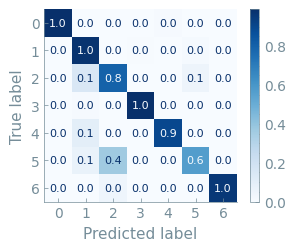

In [71]:
index_maxsize = compiled_res[compiled_res["train_size"]==max(compiled_res["train_size"])].index
conf_mats_max = [conf_mats[i] for i in index_maxsize]

actual_all, predicted_all = [], []
for index, _ in enumerate(conf_mats_max):
    preds = conf_mats_max[index]
    actual = preds["all_y_true"]
    predicted = preds["all_y_pred"]
    
    for true, pred in zip(actual, predicted):
        actual_all.append(true)
        predicted_all.append(pred)

confusion_matrix = metrics.confusion_matrix(actual_all, predicted_all)
confusion_matrix_norm = confusion_matrix.astype("float") / confusion_matrix.sum(axis=1)[:, np.newaxis]
print(confusion_matrix_norm)

cm = pycm.ConfusionMatrix(list(actual_all), list(predicted_all))
acc = cm.Overall_ACC

print(f'accuracy: {acc}')

plt.rcParams.update({'font.size': 8})
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix_norm, display_labels = [0, 1, 2, 3, 4, 5, 6])
cm_display.plot(cmap=plt.cm.Blues, include_values=True, values_format=".1f")
#plt.savefig('classif_struct_type_confusionMatrix_7cat_unbalanced_30ep_size1800_XGBoost.pdf', bbox_inches='tight')